# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import json # original json library

import pandas as pd
import logging

from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

import sklearn
import shap

/home/benjamin/anaconda3/envs/cyber/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/benjamin/anaconda3/envs/cyber/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

## Log set-up

In [2]:
LOG_FILENAME = '/home/benjamin/Folders_Python/Cyber/logs/logfile.log'
LOG_FORMAT = '%(asctime)% -- %(name)s -- %(levelname)s -- %(message)s'
# LOG_LEVEL = logging.INFO

In [3]:
# specific logger for the module
logger = logging.getLogger(__name__)   # creates specific logger for the module
logger.setLevel(logging.DEBUG)    # entry level of messages from all handlers
LOG_FORMAT = '%(asctime)s -- %(name)s -- %(levelname)s -- %(message)s'
formatter = logging.Formatter(LOG_FORMAT)

# file handler to log everything
file_handler = logging.FileHandler(LOG_FILENAME, mode='w')
file_handler.setLevel(logging.INFO)  # all messages (DEBUG and up) get logged in the file
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# stream handler to show messages to the console
console = logging.StreamHandler()
console.setLevel(logging.WARNING)  # Warning messages and up get displayed to the console
console.setFormatter(formatter)
logger.addHandler(console)

# start your engine
logger.info("-------- new run --------")

# Import pcap file

In [4]:
# NB : tshark -r <file>.pcap -T json > <file_pcap>.json -t r
# commande shell qui prend un pcap et le passe en json

!rm /home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json
!tshark -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/input.pcap -T json -t r > /home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json

#------------------------------------------------------------------------------------------------------------
#-- NB : On passe par le JSON depuis le pcap pour parser les paquets et créer la df 'raw packets' 
#-- A RE ECRIRE CAR ABSOLUMENT PAS OPTIMAL !!  UTILISER pyshark
#------------------------------------------------------------------------------------------------------------

logger.info("run tshark to create json translation of input.pcap")

In [5]:
class Packet():
    """Utility self-made unperfect class to parse the json object and extract features from a packet-like dict
    """
    
    def __init__(self, raw_packet:dict) -> None:
        self.raw_packet = raw_packet
        self._packet_data = None
        # logger.debug('constructor of Packet instance has finished')
        
    @property
    def packet_data(self):
        # returns the full dictionnary of features
        if self._packet_data is not None:
            return self._packet_data
        else:
            sl = self.raw_packet.get('_source').get('layers')
            slf = sl.get('frame')
            sle = sl.get('eth')
            sli = sl.get('ip', {})  # return empty dict as default not found value so it can handle another get method
            slu = sl.get('udp', {})
            slt = sl.get('tcp', {})
                                               
            self._packet_data = {
                'frame_time' : slf.get('frame.time'),
                'frame_time_relative' : slf.get('frame.time_relative'),
                'frame_length' : slf.get("frame.len"),
                'frame_protocols' : slf.get("frame.protocols"),
                'eth_source': sle.get("eth.src"),
                'eth_dest': sle.get("eth.dst") ,
                'ip_version': sli.get("ip.version"),
                'ip_header_length': sli.get("ip.hdr_len"),
                'ip_length': sli.get("ip.len"),
                'ip_id': sli.get("ip.id"),
                'ip_flags': sli.get("ip.flags"),
                'ip_ttl': sli.get("ip.ttl"),
                'ip_proto': sli.get("ip.proto"),
                'ip_source': sli.get("ip.src"),
                'ip_dest': sli.get("ip.dst"),
                'udp_source_port': slu.get("udp.srcport"),
                'udp_dest_port': slu.get("udp.port"),
                'udp_length': slu.get("udp.length"),
                'tcp_source_port': slt.get("tcp.srcport"),
                'tcp_dest_port': slt.get("tcp.dstport"),
                'tcp_length': slt.get("tcp.len"),
                'tcp_flags': slt.get("tcp.flags"),
            }
            # logger.debug('packet_data @property method has finished')
            return self._packet_data
        
    @packet_data.setter
    def packet_data(self, input):
        """illegal attempt to write packet_data"""
        logger.warning('Illegal attempt to write a data_packet in a packet object')
        pass

In [6]:
PCAP_FILENAME = "/home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json"

with open (PCAP_FILENAME, errors='replace') as raw_packets:  # NB : errors='replace' bypasses decoding errors
    json_object = json.load(raw_packets)    # load le fichier json dans une structure Python (list of dicts)

In [7]:
# Exemple : premier dict de la liste : c'est un paquet (=une frame Ethernet)

json_object[0]

{'_index': 'packets-2011-01-25',
 '_type': 'doc',
 '_score': None,
 '_source': {'layers': {'frame': {'frame.encap_type': '1',
    'frame.time': 'Jan 25, 2011 19:52:22.484409000 CET',
    'frame.offset_shift': '0.000000000',
    'frame.time_epoch': '1295981542.484409000',
    'frame.time_delta': '0.000000000',
    'frame.time_delta_displayed': '0.000000000',
    'frame.time_relative': '0.000000000',
    'frame.number': '1',
    'frame.len': '997',
    'frame.cap_len': '997',
    'frame.marked': '0',
    'frame.ignored': '0',
    'frame.protocols': 'eth:ethertype:ip:tcp:http'},
   'eth': {'eth.dst': '00:1a:8c:15:f9:80',
    'eth.dst_tree': {'eth.dst_resolved': '00:1a:8c:15:f9:80',
     'eth.dst.oui': '6796',
     'eth.dst.oui_resolved': 'Sophos Ltd',
     'eth.addr': '00:1a:8c:15:f9:80',
     'eth.addr_resolved': '00:1a:8c:15:f9:80',
     'eth.addr.oui': '6796',
     'eth.addr.oui_resolved': 'Sophos Ltd',
     'eth.dst.lg': '0',
     'eth.lg': '0',
     'eth.dst.ig': '0',
     'eth.ig': 

In [8]:
# exemple d'instanciation d'un objet Packet
p = Packet(json_object[0])

p.packet_data

{'frame_time': 'Jan 25, 2011 19:52:22.484409000 CET',
 'frame_time_relative': '0.000000000',
 'frame_length': '997',
 'frame_protocols': 'eth:ethertype:ip:tcp:http',
 'eth_source': '40:61:86:9a:f1:f5',
 'eth_dest': '00:1a:8c:15:f9:80',
 'ip_version': '4',
 'ip_header_length': '20',
 'ip_length': '983',
 'ip_id': '0x000076e0',
 'ip_flags': '0x00000040',
 'ip_ttl': '128',
 'ip_proto': '6',
 'ip_source': '192.168.3.131',
 'ip_dest': '72.14.213.138',
 'udp_source_port': None,
 'udp_dest_port': None,
 'udp_length': None,
 'tcp_source_port': '57011',
 'tcp_dest_port': '80',
 'tcp_length': '943',
 'tcp_flags': '0x00000018'}

# Produce DataFrame for Raw Packets analysis

In [9]:
# créé la liste de dictionnaires des data des objets Packets
packets = [ Packet(d).packet_data for d in json_object ]

df_packets = pd.DataFrame(packets)

df_packets

,frame_time,frame_time_relative,frame_length,frame_protocols,eth_source,eth_dest,ip_version,ip_header_length,ip_length,ip_id,...,ip_proto,ip_source,ip_dest,udp_source_port,udp_dest_port,udp_length,tcp_source_port,tcp_dest_port,tcp_length,tcp_flags
0,"Jan 25, 2011 19:52:22.484409000 CET",0.000000000,997,eth:ethertype:ip:tcp:http,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,4,20,983,0x000076e0,...,6,192.168.3.131,72.14.213.138,None,None,None,57011,80,943,0x00000018
1,"Jan 25, 2011 19:52:22.514250000 CET",0.029841000,440,eth:ethertype:ip:tcp:http:data-text-lines,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,4,20,426,0x00002d62,...,6,72.14.213.138,192.168.3.131,None,None,None,80,57011,386,0x00000018
2,"Jan 25, 2011 19:52:22.708292000 CET",0.223883000,66,eth:ethertype:ip:tcp,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,4,20,52,0x00002e9e,...,6,192.168.3.131,72.14.213.102,None,None,None,55950,80,0,0x00000002
3,"Jan 25, 2011 19:52:22.713832000 CET",0.229423000,54,eth:ethertype:ip:tcp,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,4,20,40,0x000076ef,...,6,192.168.3.131,72.14.213.138,None,None,None,57011,80,0,0x00000010
4,"Jan 25, 2011 19:52:22.727058000 CET",0.242649000,66,eth:ethertype:ip:tcp,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,4,20,52,0x00009415,...,6,72.14.213.102,192.168.3.131,None,None,None,80,55950,0,0x00000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14256,"Jan 25, 2011 19:57:20.768972000 CET",298.284563000,54,eth:ethertype:ip:tcp,08:00:27:cc:3f:1b,52:54:00:12:35:02,4,20,40,0x000088b3,...,6,10.0.2.15,65.54.167.27,None,None,None,2548,5480,0,0x00000014
14257,"Jan 25, 2011 19:57:20.787428000 CET",298.303019000,162,eth:ethertype:ip:udp:db-lsp-disc:json,40:61:86:9a:f1:f5,ff:ff:ff:ff:ff:ff,4,20,148,0x000035d7,...,17,192.168.3.131,255.255.255.255,17500,17500,128,None,None,None,None
14258,"Jan 25, 2011 19:57:20.789753000 CET",298.305344000,162,eth:ethertype:ip:udp:db-lsp-disc:json,40:61:86:9a:f1:f5,ff:ff:ff:ff:ff:ff,4,20,148,0x000035d8,...,17,192.168.3.131,192.168.3.255,17500,17500,128,None,None,None,None
14259,"Jan 25, 2011 19:57:20.987428000 CET",298.503019000,162,eth:ethertype:ip:udp:db-lsp-disc:json,40:61:86:9a:f1:f5,ff:ff:ff:ff:ff:ff,4,20,148,0x000035d7,...,17,192.168.3.131,255.255.255.255,17500,17500,128,None,None,None,None


In [10]:
df_packets.describe(include='all').transpose()

,count,unique,top,freq
frame_time,14261,14123,"Jan 25, 2011 19:57:15.280863000 CET",4
frame_time_relative,14261,14123,292.796454000,4
frame_length,14261,857,1514,4378
frame_protocols,14261,44,eth:ethertype:ip:tcp,10315
eth_source,14261,8,00:1a:8c:15:f9:80,6170
eth_dest,14261,12,40:61:86:9a:f1:f5,6184
ip_version,14243,1,4,14243
ip_header_length,14243,1,20,14243
ip_length,14243,858,40,5319
ip_id,14243,11304,0x00000000,79


# EVE JSON Output by Suricata

In [11]:
# run Suricata to produce an eve.json file with alerts

!rm /home/benjamin/Folders_Python/Cyber/data/outputs/eve.json
!suricata -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/input.pcap -l /home/benjamin/Folders_Python/Cyber/data/outputs -k none
# !suricata -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/bigFlows.pcap -l /home/benjamin/Folders_Python/Cyber/data/outputs -k none

logger.info("run Suricata to reassemble flows and create alert logs")

24/6/2023 -- 20:40:54 - <Info> - Configuration node 'af-packet' redefined.
24/6/2023 -- 20:40:54 - <Notice> - This is Suricata version 6.0.1 RELEASE running in USER mode
24/6/2023 -- 20:42:47 - <Warning> - [ERRCODE: SC_ERR_INITIALIZATION(45)] - Unix socket: UNIX socket bind(/var/run/suricata-command.socket) error: Address already in use
24/6/2023 -- 20:42:47 - <Warning> - [ERRCODE: SC_ERR_INITIALIZATION(45)] - Unable to create unix command socket
24/6/2023 -- 20:42:47 - <Notice> - all 5 packet processing threads, 4 management threads initialized, engine started.
24/6/2023 -- 20:42:47 - <Notice> - Signal Received.  Stopping engine.
24/6/2023 -- 20:42:48 - <Notice> - Pcap-file module read 1 files, 14261 packets, 9216531 bytes


In [12]:
# Pandas provides a useful method – json_normalize – for normalizing nested JSON fields into dataframe. Resulting columns use dot notation to signify nested objects, similar to how Elasticsearch does it

SURICATA_EVE_LOG = "/home/benjamin/Folders_Python/Cyber/data/outputs/eve.json"

with open (SURICATA_EVE_LOG) as packets:
    df_log = pd.json_normalize(
        [json.loads(packet) for packet in packets],
        max_level=1
    )

In [13]:
df_log

,timestamp,flow_id,pcap_cnt,event_type,src_ip,src_port,dest_ip,dest_port,proto,tx_id,...,stats.uptime,stats.decoder,stats.flow,stats.defrag,stats.flow_bypassed,stats.tcp,stats.detect,stats.app_layer,stats.http,stats.ftp
0,2011-01-25T19:52:23.466591+0100,1.511290e+15,100.0,http,192.168.3.131,55953.0,65.55.206.209,80.0,TCP,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-25T19:52:23.832607+0100,1.670178e+15,161.0,http,192.168.3.131,55959.0,65.55.5.231,80.0,TCP,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-25T19:52:23.832607+0100,1.670178e+15,161.0,fileinfo,65.55.5.231,80.0,192.168.3.131,55959.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-25T19:52:23.998656+0100,1.442940e+15,174.0,http,192.168.3.131,55962.0,65.55.5.232,80.0,TCP,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-25T19:52:23.998656+0100,1.442940e+15,174.0,fileinfo,65.55.5.232,80.0,192.168.3.131,55962.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,2011-01-25T19:52:22.484409+0100,2.251403e+15,NaN,flow,192.168.3.131,57173.0,208.50.77.73,5480.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028,2011-01-25T19:52:22.484409+0100,1.688648e+15,NaN,flow,192.168.3.131,56110.0,65.54.95.68,80.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029,2011-01-25T19:52:22.484409+0100,4.220540e+14,NaN,flow,172.16.255.1,50983.0,2.120.66.172,23852.0,UDP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030,2011-01-25T19:52:22.484409+0100,5.629354e+14,NaN,flow,172.16.255.1,50983.0,65.35.35.4,34467.0,UDP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_log[df_log['event_type']=='flow']

,timestamp,flow_id,pcap_cnt,event_type,src_ip,src_port,dest_ip,dest_port,proto,tx_id,...,stats.uptime,stats.decoder,stats.flow,stats.defrag,stats.flow_bypassed,stats.tcp,stats.detect,stats.app_layer,stats.http,stats.ftp
483,2011-01-25T19:52:22.484409+0100,1.277983e+15,NaN,flow,192.168.3.131,56039.0,65.54.95.140,80.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1089,2011-01-25T19:52:22.484409+0100,2.144132e+15,NaN,flow,10.0.2.15,2531.0,207.46.125.253,7001.0,UDP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1090,2011-01-25T19:52:22.484409+0100,2.136075e+15,NaN,flow,172.16.255.1,137.0,172.16.255.255,137.0,UDP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1091,2011-01-25T19:52:22.484409+0100,8.436673e+14,NaN,flow,10.0.2.15,48575.0,10.0.2.2,1900.0,UDP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164,2011-01-25T19:52:22.484409+0100,6.390207e+14,NaN,flow,192.168.3.131,57011.0,72.14.213.138,80.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,2011-01-25T19:52:22.484409+0100,8.436674e+14,NaN,flow,10.0.2.15,48575.0,10.0.2.2,1900.0,UDP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,2011-01-25T19:52:22.484409+0100,2.251403e+15,NaN,flow,192.168.3.131,57173.0,208.50.77.73,5480.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028,2011-01-25T19:52:22.484409+0100,1.688648e+15,NaN,flow,192.168.3.131,56110.0,65.54.95.68,80.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029,2011-01-25T19:52:22.484409+0100,4.220540e+14,NaN,flow,172.16.255.1,50983.0,2.120.66.172,23852.0,UDP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Produce DataFrame for Flow Analysis

In [15]:
# from Suricata doc :

# 15.1.2.12. Event type: Flow
# 15.1.2.12.1. Fields

#     “pkts_toserver”: total number of packets to server, include bypassed packets
#     “pkts_toclient”: total number of packets to client
#     “bytes_toserver”: total bytes count to server
#     “bytes_toclient”: total bytes count to client
#     “bypassed.pkts_toserver”: number of bypassed packets to server
#     “bypassed.pkts_toclient”: number of bypassed packets to client
#     “bypassed.bytes_toserver”: bypassed bytes count to server
#     “bypassed.bytes_toclient”: bypassed bytes count to client
#     “start”: date of start of the flow
#     “end”: date of end of flow (last seen packet)
#     “age”: duration of the flow
#     “bypass”: if the flow has been bypassed, it is set to “local” (internal bypass) or “capture”
#     “state”: display state of the flow (include “new”, “established”, “closed”, “bypassed”)
#     “reason”: mechanism that did trigger the end of the flow (include “timeout”, “forced” and “shutdown”)
#     “alerted”: “true” or “false” depending if an alert has been seen on flow

In [16]:
# https://www.stamus-networks.com/blog/jupyter-playbooks-for-suricata-part-1

# https://malware-traffic-analysis.net/

In [17]:
class Flow():
    """Utility class - takes a event-flow string out of eve.json,
       creates a one-level dict structure, suitable for dataframe creation
    """
    def __init__(self, flow_event:dict):
        if flow_event.get('event_type') != 'flow':
            logger.critical("Attempt to build a Flow instance with a non-flow event")
            raise ValueError
        self._raw_flow_event = flow_event
        self._features = None
        
    @property
    def features(self):
        if self._features is not None:
            return self._features
        else:
            keys_list_first_level = [
                'timestamp',
                'flow_id',
                'src_ip',
                'src_port',
                'dest_ip',
                'dest_port',
                'proto'
            ]
            keys_list_second_level = [
                'pkts_toserver',
                'pkts_toclient',
                'bytes_toserver',
                'bytes_toclient',
                'start',
                'end',
                'age',
                'state',
                'reason',
                'alerted'
            ]
            d1 = { k: self._raw_flow_event.get(k) for k in keys_list_first_level }
            d2 = { k: self._raw_flow_event.get('flow').get(k) for k in keys_list_second_level }
            self._features = { **d1, **d2 }
            # logger.info("built a Flow features object")
            return self._features
        
    @features.setter
    def features(self, input):
        logger.critical("illegal attempt to hard write features in a Flow object")
        
    def __str__(self) -> str:
        return json.dumps(self.features, indent=4)
    
    def __repr__(self) -> str:
        return json.dumps(self.features, indent=4)


In [18]:
# exemple de flow JSON = 
# {
# "timestamp":"2023-06-17T10:46:05.765744+0200",
# "flow_id":860724109937755,
# "event_type":"flow",
# "src_ip":"2a01:cb19:872e:3000:0e4f:3187:540c:d66c",
# "src_port":47864,
# "dest_ip":"2a00:1450:4007:081a:0000:0000:0000:2003",
# "dest_port":80,
# "proto":"TCP",
# "flow":
#     {"pkts_toserver":6,
#     "pkts_toclient":5,
#     "bytes_toserver":516,
#     "bytes_toclient":430,
#     "start":"2023-06-17T10:46:10.625755+0200",
#     "end":"2023-06-17T10:46:44.150502+0200",
#     "age":34,
#     "state":"new",
#     "reason":"shutdown",
#     "alerted":true},
# "community_id":"1:uRhWV544zvWeIohZCmryZHXZ5EA=",
# "tcp":
#     {"tcp_flags":"00",
#     "tcp_flags_ts":"00",
#     "tcp_flags_tc":"00"
#     }
# }'

In [19]:
SURICATA_EVE_LOG = "/home/benjamin/Folders_Python/Cyber/data/outputs/eve.json"

i=0
columns_names =  [
                'timestamp',
                'flow_id',
                'src_ip',
                'src_port',
                'dest_ip',
                'dest_port',
                'proto'
            ] + [
                'pkts_toserver',
                'pkts_toclient',
                'bytes_toserver',
                'bytes_toclient',
                'start',
                'end',
                'age',
                'state',
                'reason',
                'alerted'
            ]
dict_for_dataframe = { k:[] for k in columns_names }

with open (SURICATA_EVE_LOG) as f:
    for event_string in f:
        python_object = json.loads(event_string)
        if python_object.get('event_type')=='flow':
            flow = Flow(python_object)
            for k in columns_names:
                if dict_for_dataframe[k] == []:
                    dict_for_dataframe[k] = [flow.features.get(k)]
                else:
                    dict_for_dataframe[k].append(flow.features.get(k))

In [20]:
df_flow = pd.DataFrame(data=dict_for_dataframe)

In [21]:
df_flow

,timestamp,flow_id,src_ip,src_port,dest_ip,dest_port,proto,pkts_toserver,pkts_toclient,bytes_toserver,bytes_toclient,start,end,age,state,reason,alerted
0,2011-01-25T19:52:22.484409+0100,1277983021167133,192.168.3.131,56039.0,65.54.95.140,80.0,TCP,14,18,3170,18651,2011-01-25T19:52:49.750109+0100,2011-01-25T19:53:03.287680+0100,14,closed,timeout,False
1,2011-01-25T19:52:22.484409+0100,2144131901698671,10.0.2.15,2531.0,207.46.125.253,7001.0,UDP,1,0,62,0,2011-01-25T19:54:18.930415+0100,2011-01-25T19:54:18.930415+0100,0,new,timeout,False
2,2011-01-25T19:52:22.484409+0100,2136074541908578,172.16.255.1,137.0,172.16.255.255,137.0,UDP,6,0,552,0,2011-01-25T19:54:00.639586+0100,2011-01-25T19:54:17.717731+0100,17,new,timeout,False
3,2011-01-25T19:52:22.484409+0100,843667344159722,10.0.2.15,48575.0,10.0.2.2,1900.0,UDP,10,0,1745,0,2011-01-25T19:54:19.160746+0100,2011-01-25T19:54:21.186212+0100,2,new,timeout,False
4,2011-01-25T19:52:22.484409+0100,639020734768185,192.168.3.131,57011.0,72.14.213.138,80.0,TCP,6,3,3163,1496,2011-01-25T19:52:22.484409+0100,2011-01-25T19:52:24.437888+0100,2,new,timeout,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2011-01-25T19:52:22.484409+0100,843667351368682,10.0.2.15,48575.0,10.0.2.2,1900.0,UDP,10,0,1745,0,2011-01-25T19:56:09.160746+0100,2011-01-25T19:56:11.186212+0100,2,new,shutdown,False
637,2011-01-25T19:52:22.484409+0100,2251403010855689,192.168.3.131,57173.0,208.50.77.73,5480.0,TCP,2,1,108,60,2011-01-25T19:55:49.807689+0100,2011-01-25T19:55:49.885212+0100,0,new,shutdown,False
638,2011-01-25T19:52:22.484409+0100,1688648468021380,192.168.3.131,56110.0,65.54.95.68,80.0,TCP,16,28,1553,35375,2011-01-25T19:53:10.606340+0100,2011-01-25T19:53:23.287014+0100,13,closed,shutdown,False
639,2011-01-25T19:52:22.484409+0100,422054027862266,172.16.255.1,50983.0,2.120.66.172,23852.0,UDP,1,1,60,68,2011-01-25T19:54:32.794874+0100,2011-01-25T19:54:33.013863+0100,1,established,shutdown,False


# Some Machine Learning

In [22]:
df_flow.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
timestamp,641,1,2011-01-25T19:52:22.484409+0100,641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flow_id,641.0,NaN,NaN,NaN,1130828265405544.25,642896101093201.5,6408566975086.0,593208474053515.0,1143237019230473.0,1667085588329153.0,2251403010855689.0
src_ip,641,16,192.168.3.131,333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_port,640.0,NaN,NaN,NaN,41413.835938,22681.086579,67.0,10683.75,55953.5,56482.75,64982.0
dest_ip,641,213,192.168.3.131,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dest_port,640.0,NaN,NaN,NaN,11156.175,19417.664358,53.0,80.0,302.0,8578.25,64588.0
proto,641,3,TCP,487,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pkts_toserver,641.0,NaN,NaN,NaN,9.483619,15.654576,1.0,2.0,5.0,9.0,170.0
pkts_toclient,641.0,NaN,NaN,NaN,12.705148,28.531049,0.0,1.0,5.0,10.0,354.0
bytes_toserver,641.0,NaN,NaN,NaN,2172.232449,6070.227997,54.0,124.0,779.0,1553.0,64957.0


In [23]:
df_flow.dtypes

timestamp          object
flow_id             int64
src_ip             object
src_port          float64
dest_ip            object
dest_port         float64
proto              object
pkts_toserver       int64
pkts_toclient       int64
bytes_toserver      int64
bytes_toclient      int64
start              object
end                object
age                 int64
state              object
reason             object
alerted              bool
dtype: object

In [24]:
df = df_flow.copy(deep=True)

In [25]:
# codage en ordinal

df['src_ip_ord'], uniques_src_ip = pd.factorize(values=df['src_ip'])
df['dest_ip_ord'], uniques_dest_ip = pd.factorize(values=df['dest_ip'])
df['proto_ord'], uniques_proto = pd.factorize(values=df['proto'])

In [26]:
# Flows flagged as 'alerted' by Suricata

df[df['alerted']==True]

,timestamp,flow_id,src_ip,src_port,dest_ip,dest_port,proto,pkts_toserver,pkts_toclient,bytes_toserver,bytes_toclient,start,end,age,state,reason,alerted,src_ip_ord,dest_ip_ord,proto_ord
15,2011-01-25T19:52:22.484409+0100,2132683671332080,172.16.255.1,10696.0,109.227.83.224,443.0,TCP,9,7,637,577,2011-01-25T19:55:33.713968+0100,2011-01-25T19:55:46.380435+0100,13,closed,shutdown,True,2,12,0
18,2011-01-25T19:52:22.484409+0100,1427134348854494,192.168.3.131,55968.0,72.14.213.101,80.0,TCP,14,11,5654,1850,2011-01-25T19:52:25.001246+0100,2011-01-25T19:55:36.284026+0100,191,established,shutdown,True,0,15,0
19,2011-01-25T19:52:22.484409+0100,1716862108530352,192.168.3.131,56126.0,66.235.139.121,80.0,TCP,6,11,336,3255,2011-01-25T19:53:15.554672+0100,2011-01-25T19:53:26.815614+0100,11,closed,shutdown,True,0,16,0
21,2011-01-25T19:52:22.484409+0100,1999582630628890,172.16.255.1,10684.0,109.229.25.126,443.0,TCP,10,8,699,611,2011-01-25T19:54:29.708122+0100,2011-01-25T19:54:52.918948+0100,23,closed,shutdown,True,2,17,0
29,2011-01-25T19:52:22.484409+0100,998988394646549,172.16.255.1,10683.0,109.173.29.34,443.0,TCP,9,7,611,541,2011-01-25T19:54:29.707605+0100,2011-01-25T19:55:27.360854+0100,58,closed,shutdown,True,2,22,0
30,2011-01-25T19:52:22.484409+0100,579344320363677,172.16.255.1,10688.0,213.146.189.205,443.0,TCP,13,11,1317,1041,2011-01-25T19:54:34.785565+0100,2011-01-25T19:57:07.947680+0100,153,closed,shutdown,True,2,23,0
34,2011-01-25T19:52:22.484409+0100,1291089121628352,192.168.3.131,56361.0,66.235.133.62,80.0,TCP,3,4,174,978,2011-01-25T19:54:47.839872+0100,2011-01-25T19:54:58.110957+0100,11,closed,shutdown,True,0,27,0
36,2011-01-25T19:52:22.484409+0100,2136390224232878,192.168.3.131,56317.0,66.235.139.121,80.0,TCP,3,8,174,2516,2011-01-25T19:54:34.704942+0100,2011-01-25T19:54:45.796803+0100,11,closed,shutdown,True,0,16,0
37,2011-01-25T19:52:22.484409+0100,447645585519685,192.168.3.131,56134.0,66.235.133.62,80.0,TCP,4,6,228,1832,2011-01-25T19:53:16.341061+0100,2011-01-25T19:53:41.306368+0100,25,closed,shutdown,True,0,27,0
39,2011-01-25T19:52:22.484409+0100,735036885694217,192.168.3.131,56356.0,66.235.139.121,80.0,TCP,3,8,174,2515,2011-01-25T19:54:47.521993+0100,2011-01-25T19:54:59.095974+0100,12,closed,shutdown,True,0,16,0


### PCA

In [27]:
columns_names = ['src_port', 'dest_port', 'pkts_toserver', 'pkts_toclient', 'bytes_toserver', 'bytes_toclient', 'age', 'src_ip_ord', 'dest_ip_ord', 'proto_ord', 'alerted']
features_names = ['src_port', 'dest_port', 'pkts_toserver', 'pkts_toclient', 'bytes_toserver', 'bytes_toclient', 'age', 'src_ip_ord', 'dest_ip_ord', 'proto_ord']

df_clean = df[columns_names].dropna()

X = df_clean[features_names].to_numpy()
y = df_clean['alerted']

In [28]:
pca = PCA(n_components=0.90)  # scikit learn trick : when 0 < n_components < 1, choose the number of components so that the explained variance is above 90%

X_new = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

[0.61014679 0.25841565 0.11847242]


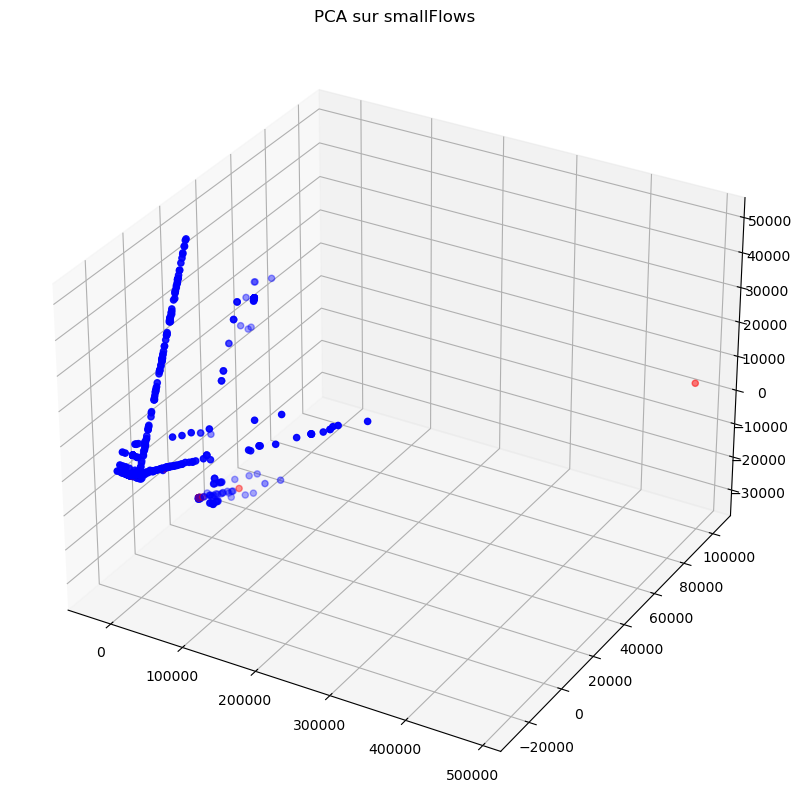

In [29]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

xs = X_new[:,0]
ys = X_new[:,1]
zs = X_new[:,2]

colors = [ 'red' if c == True else 'blue' for c in list(y)]

ax.scatter3D(xs, ys, zs, c=colors)
ax.set_title("PCA sur smallFlows")
plt.show()

### Classifiers

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

In [31]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### A couple of classifiers : Logistic Regression, SVM Linear, Random Forest

In [32]:
clf_lr = sklearn.linear_model.LogisticRegression(random_state=42, max_iter=1000)
clf_lr.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [33]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability=True)
clf_svm.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [34]:
clf_rf = sklearn.ensemble.RandomForestClassifier()
clf_rf.fit(X_train, Y_train)

RandomForestClassifier()

In [35]:
models = {
    "Logistic_Regression" : clf_lr,
    "SVM_linear_kernel" : clf_svm,
    "Random_Forest" : clf_rf
}

In [36]:
roc_curve_params = {}

Accuracy of Logistic_Regression = 95.31%


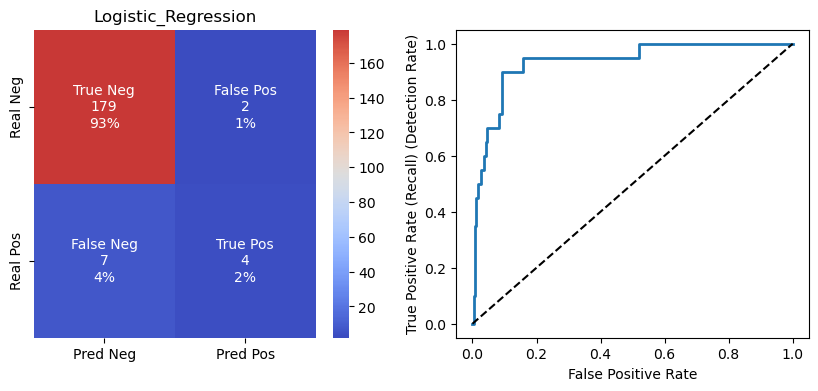

Accuracy of SVM_linear_kernel = 93.75%


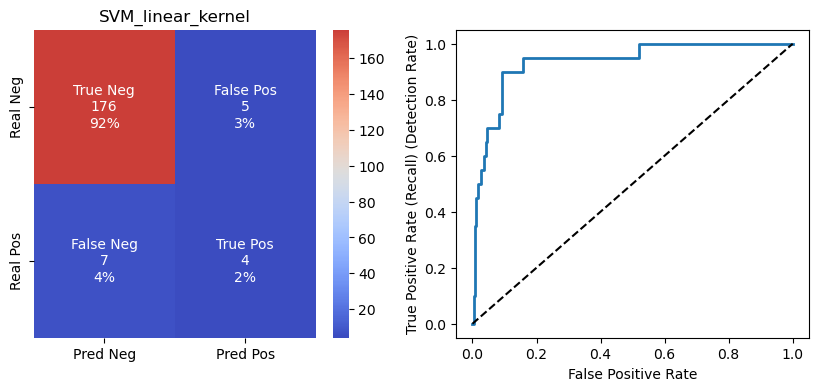

Accuracy of Random_Forest = 96.88%


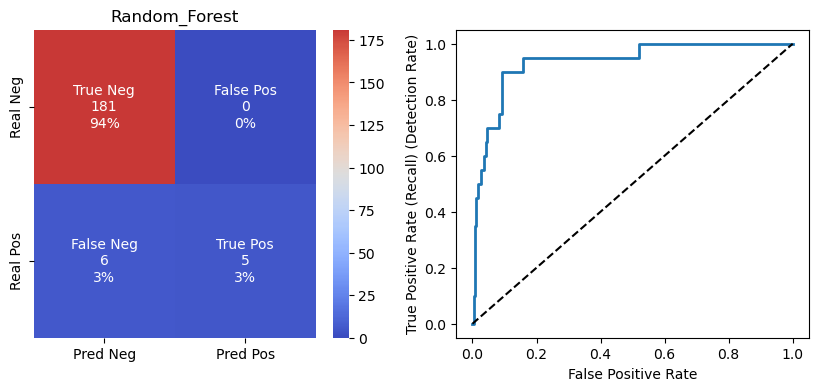

In [37]:
for name, model in models.items():
    print(f"Accuracy of {name} = {model.score(X_test, Y_test)*100:.2f}%")

    Y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(Y_test, Y_pred)

    # print(cf_matrix)

    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = [ f'{value:0}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value*100:.0f}%' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [ f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages) ]
    labels = np.asarray(labels).reshape(2,2)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="coolwarm", center = np.sum(cf_matrix)/2, xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["Real Neg", "Real Pos"], ax=ax[0])
    ax[0].set_title(name)

    Y_scores = cross_val_predict(clf_lr, X_train, Y_train, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(Y_train, Y_scores[:,1])
    
    roc_curve_params[name] = [ fpr, tpr, thresholds ]

    # fig, ax = plt.subplots()

    ax[1].plot(fpr, tpr, linewidth=2)
    ax[1].plot([0,1], [0,1], 'k--')
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate (Recall) (Detection Rate)")
    plt.show()

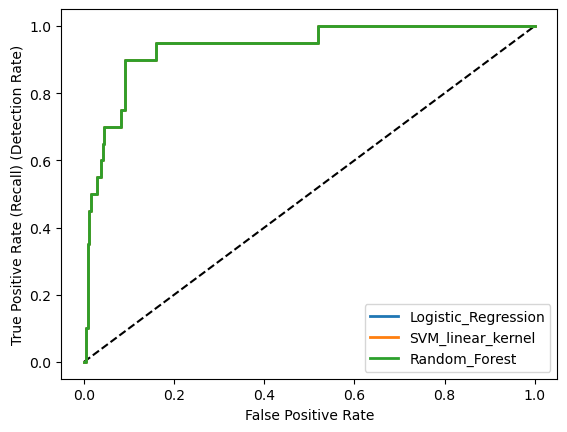

In [38]:
fig, ax = plt.subplots()
    
ax.plot([0,1], [0,1], 'k--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate (Recall) (Detection Rate)")
    
for name, list_params in roc_curve_params.items():
    ax.plot(list_params[0], list_params[1], linewidth=2, label=name)

ax.legend()  
plt.show()

## Explainability

### PCA

In [39]:
# expression of the eigen vectors in the features space

pca.components_

array([[ 1.10962443e-01, -1.35837543e-01,  3.63253832e-04,
         7.26539280e-04,  7.18948210e-02,  9.81868548e-01,
         1.68304425e-04, -1.11663413e-05, -3.14593040e-04,
        -2.18924917e-06],
       [-8.42914247e-01,  5.11711586e-01,  6.81518637e-05,
         1.38423910e-04, -2.71599854e-03,  1.66251012e-01,
         7.08894351e-05,  5.07583279e-05,  1.35005809e-04,
        -3.83565676e-07],
       [ 5.26461848e-01,  8.48102988e-01, -7.54719874e-05,
        -3.68549018e-05, -1.09252663e-02,  5.86358746e-02,
        -4.83782405e-04,  1.82234270e-05,  1.21442117e-03,
         1.03673341e-05]])

### SHAP

In [40]:
# X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# svc_linear = sklearn.svm.SVC(kernel='linear', probability=True)
# svc_linear.fit(X_train, Y_train)

# print(f"Accuracy = {svc_linear.score(X_test, Y_test)*100:.2f}%")

In [41]:
# shap.initjs()

# explainer = shap.KernelExplainer(clf.predict_proba, X_train)
# shap_values = explainer.shap_values(X_test)
# # shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [42]:
# shap.summary_plot(shap_values, X_train, feature_names=features_names)

In [43]:
# clf = sklearn.ensemble.RandomForestClassifier()
# clf.fit(X_train, Y_train)

# Y_pred = clf.predict(X_test)
# cf_matrix = confusion_matrix(Y_test, Y_pred)

# print(cf_matrix)

# Y_scores = cross_val_predict(clf, X_train, Y_train, cv=3, method="predict_proba")

# fpr, tpr, thresholds = roc_curve(Y_train, Y_scores[:,1])

In [44]:
# Y_scores

In [45]:
# fig, ax = plt.subplots()

# ax.plot(fpr, tpr, linewidth=2)
# ax.plot([0,1], [0,1], 'k--')
# ax.set_xlabel("False Positive Rate")
# ax.set_ylabel("True Positive Rate (Recall) (Detection Rate)")
# plt.show()